In [9]:
import os
import pathlib
import pandas as pd
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [10]:
!pip install ktrain
import ktrain
from ktrain import text
MODEL_NAME="Musixmatch/umberto-commoncrawl-cased-v1"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
train_path= "../input/dati-di-training-e-di-test/haspeede2_dev_taskAB.csv"
test_path="../input/dati-di-training-e-di-test/haspeede2_reference_taskAB-tweets.csv"
tr_path=pathlib.Path(train_path)
te_path=pathlib.Path(test_path)
if tr_path.exists():
    print("Train data path set.")
else:
    raise SystemExit("Training Data Path does not exist.")

if te_path.exists():
    print("Test data path set.")
else:
    raise SystemExit("Test Data Path does not exist.")

Train data path set.
Test data path set.


In [12]:
train_df= pd.read_csv(train_path, encoding='utf-8', sep="\t", header=None)
train_df=train_df.drop([0])
train_df.head()


,0,1,2,3
1,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
2,2045,@user @user infatti finché ci hanno guadagnato...,0,0
3,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
4,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
5,949,Il divertimento del giorno? Trovare i patrioti...,0,0


In [13]:
test_df= pd.read_csv(test_path, encoding='utf-8', sep="\t",header=None)
test_df.head()


,0,1,2,3
0,11834,@user A me pare una scelta politica suicida pu...,1,0
1,12113,@user e' un perfetto musulmano!!! chi dice il ...,1,1
2,11770,Mai Tg e i giornaloni hanno parlato di questa ...,1,1
3,11937,@user Ipocriti farabutti. Fanno morire i terre...,1,1
4,11870,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1,1


In [14]:
x_train=train_df[1].tolist()
y_train=train_df[2].tolist()
x_test=test_df[1].tolist()
y_test=test_df[2].tolist()


t=text.Transformer(MODEL_NAME,maxlen=100)
trn=t.preprocess_train(x_train,y_train)
val=t.preprocess_test(x_test,y_test)

preprocessing train...
language: it
train sequence lengths:
	mean : 23
	95percentile : 45
	99percentile : 50


Is Multi-Label? False
preprocessing test...
language: it
test sequence lengths:
	mean : 35
	95percentile : 49
	99percentile : 53


404 Client Error: Not Found for url: https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1/resolve/main/tf_model.h5
/opt/conda/lib/python3.7/site-packages/ktrain/text/preprocessor.py:1067: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


simulating training for different learning rates... this may take a few moments...
Epoch 1/10
213/213 [==============================] - 91s 361ms/step - loss: 0.6885 - accuracy: 0.5596
Epoch 2/10
213/213 [==============================] - 78s 368ms/step - loss: 0.6619 - accuracy: 0.6062
Epoch 3/10
213/213 [==============================] - 78s 367ms/step - loss: 0.5011 - accuracy: 0.7699
Epoch 4/10
213/213 [==============================] - 78s 367ms/step - loss: 0.4338 - accuracy: 0.7991
Epoch 5/10
213/213 [==============================] - 78s 367ms/step - loss: 0.5625 - accuracy: 0.7020
Epoch 6/10
213/213 [==============================] - 78s 368ms/step - loss: 0.6814 - accuracy: 0.5814
Epoch 7/10
213/213 [==============================] - 66s 311ms/step - loss: 1.4167 - accuracy: 0.5531


done.
Visually inspect loss plot and select learning rate associated with falling loss


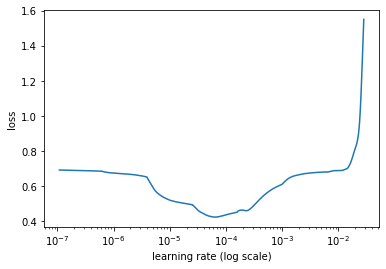



begin training using triangular learning rate policy with max lr of 0.0002...
Epoch 1/10
214/214 [==============================] - 96s 390ms/step - loss: 0.5853 - accuracy: 0.6883 - val_loss: 0.4976 - val_accuracy: 0.7561
Epoch 2/10
214/214 [==============================] - 84s 385ms/step - loss: 0.4292 - accuracy: 0.8067 - val_loss: 0.5423 - val_accuracy: 0.7387
Epoch 3/10
214/214 [==============================] - 84s 384ms/step - loss: 0.4113 - accuracy: 0.8217 - val_loss: 0.5107 - val_accuracy: 0.7641
Epoch 4/10
214/214 [==============================] - 84s 384ms/step - loss: 0.3449 - accuracy: 0.8566 - val_loss: 0.6191 - val_accuracy: 0.6904
Epoch 5/10
214/214 [==============================] - 84s 384ms/step - loss: 0.5969 - accuracy: 0.7083 - val_loss: 0.7164 - val_accuracy: 0.5075
Epoch 6/10
214/214 [==============================] - 84s 384ms/step - loss: 0.6666 - accuracy: 0.6142 - val_loss: 0.7069 - val_accuracy: 0.5075
Restoring model weights from the end of the best e

array([[422, 219],
       [ 89, 533]])

In [15]:
model=t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

learner.lr_find(show_plot=True,max_epochs=10)
learner.autofit(2e-4,early_stopping=5,epochs=10)
learner.validate(class_names=t.get_classes())

In [16]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

data=test_df[1].tolist()
label=test_df[2].tolist()

i = 0
correct = 0
wrong = 0
total = len(data)
true_lab = []
pred_lab = []
text = []
for dt in data:
    result = predictor.predict(dt)
    if not int(result) == label[i]:
        text.append(dt)
        pred_lab.append(result)
        true_lab.append(label[i])
        wrong += 1
    else:
        correct += 1

    i += 1


In [17]:
name_dict = {
    'Name': text,
    'Gold Label': true_lab,
    'Predicted Label': pred_lab
}

wrong_data = pd.DataFrame(name_dict)

wrong_data.to_csv("wrong_results.csv", sep=';')

print("Correct: ", correct,"/",total,"\nWrong: ", wrong,"/",total)

Correct:  955 / 1263 
Wrong:  308 / 1263
